# Quantum Integer Programming (QuIP) 47-779. Fall 2020, CMU

This notebook contains material from the Quantum Integer Programming Lecture at CMU Fall 2020 by David Bernal (bernalde at cmu.edu), Sridhar Tayur (stayur at cmu.edu) and Davide Venturelli; the content is available on **[Github](https://github.com/bernalde/QuIP)**. The text is released under the **[CC-BY-NC-ND-4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode) license, and code is released under the **[MIT license](https://opensource.org/licenses/MIT).*

Run in **[Google Colab](https://colab.research.google.com/github/bernalde/QuIP/blob/master/notebooks/Notebook%204%20-%20Ising%20Model.ipynb)**

## Ising model
This notebook will explain the basics of the Ising model. In order to implement the different Ising Models we will use D-Wave's packages **[dimod]()** and **[neal]()**, for defining the Ising model and solving it with simulated annealing, respectively. When posing the problems as Integer programs, we will model using **[Pyomo](http://www.pyomo.org/)**, an open-source Python package, which provides a flexible access to different solvers and a general modeling framework for linear and nonlinear integer programs.
The examples solved here will make use of open-source solver **[CBC](https://projects.coin-or.org/Cbc)** for mixed-integer linear programming.

#### Problem statement
We pose the Ising problem as the following optimization problem:
$$
\min_{\sigma \in \{ -1,+1 \}^n} H(\sigma) =\min_{\sigma \in \{ -1,+1 \}^n} \sum_{(ij) \in E(G)} J_{ij}\sigma_i\sigma_j + \sum_{i \in V(G)}h_i\sigma_i + c_I
$$
where we optimize over spins $\sigma \in \{ -1,+1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{ij}$ and the linear coefficients are $h_i$. We also include an arbitrary offset of the Ising model $c_I$.

### Example
Suppose we have an Ising model defined from
$$
J_{0, 3}=24.0,J_{0, 4}=24.0,J_{0, 5}=24.0,J_{0, 7}=24.0,J_{0, 8}=24.0,J_{0, 9}=24.0,J_{0, 10}=24.0,\\
J_{1, 3}=24.0,J_{1, 5}=24.0,J_{1, 6}=24.0,J_{1, 8}=24.0,J_{1, 9}=24.0,J_{1, 10}=24.0,\\
J_{2, 4}=24.0,J_{2, 6}=24.0,J_{2, 7}=24.0,J_{2, 8}=24.0,J_{2, 9}=24.0,J_{2, 10}=24.0,\\
J_{3, 4}=24.0,J_{3, 5}=48.0,J_{3, 6}=24.0,J_{3, 7}=24.0,J_{3, 8}=48.0,J_{3, 9}=48.0,J_{3, 10}=48.0,\\
J_{4, 5}=24.0,J_{4, 6}=24.0,J_{4, 7}=48.0,J_{4, 8}=48.0,J_{4, 9}=48.0,J_{4, 10}=48.0,\\
J_{5, 6}=24.0,J_{5, 7}=24.0,J_{5, 8}=48.0,J_{5, 9}=48.0,J_{5, 10}=48.0,\\
J_{6, 7}=24.0,J_{6, 8}=48.0,J_{6, 9}=48.0,J_{6, 10}=48.0,\\
J_{7, 8}=48.0,J_{7, 9}=48.0,J_{7, 10}=48.0,\\
J_{8, 9}=72.0,J_{8, 10}=72.0,\\
J_{9, 10}=72.0 \\
J = \begin{bmatrix}
0 & 0 & 0 & 24 & 24 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 48 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72\\
\end{bmatrix} \\
h^\top = [145.0,122.0,122.0,266.0,266.0,266.0,242.5,266.0,386.5,387.0,386.5] \\
c_I = 1319.5
$$
Let's solve this problem

In [7]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's start with Pyomo, dimod and neal
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal

In [9]:
# Import the Pyomo library, which can be installed via pip, conda or from Github https://github.com/Pyomo/pyomo
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time

In [11]:
# These could also be simple lists and numpy matrices
h = {0: 145.0, 1: 122.0, 2: 122.0, 3: 266.0, 4: 266.0, 5: 266.0, 6: 242.5, 7: 266.0, 8: 386.5, 9: 387.0, 10: 386.5}
J = {(0, 3): 24.0, (0, 4): 24.0, (0, 5): 24.0, (0, 7): 24.0, (0, 8): 24.0, (0, 9): 24.0, (0, 10): 24.0, (1, 3): 24.0, (1, 5): 24.0, (1, 6): 24.0, (1, 8): 24.0, (1, 9): 24.0, (1, 10): 24.0, (2, 4): 24.0, (2, 6): 24.0, (2, 7): 24.0, (2, 8): 24.0, (2, 9): 24.0, (2, 10): 24.0, (3, 4): 24.0, (3, 5): 48.0, (3, 6): 24.0, (3, 7): 24.0, (3, 8): 48.0, (3, 9): 48.0, (3, 10): 48.0, (4, 5): 24.0, (4, 6): 24.0, (4, 7): 48.0, (4, 8): 48.0, (4, 9): 48.0, (4, 10): 48.0, (5, 6): 24.0, (5, 7): 24.0, (5, 8): 48.0, (5, 9): 48.0, (5, 10): 48.0, (6, 7): 24.0, (6, 8): 48.0, (6, 9): 48.0, (6, 10): 48.0, (7, 8): 48.0, (7, 9): 48.0, (7, 10): 48.0, (8, 9): 72.0, (8, 10): 72.0, (9, 10): 72.0}
cI = 1319.5

model_ising = dimod.BinaryQuadraticModel.from_ising(h, J, offset=cI)



Since the problem is relatively small (11 variables, $2^{11}=2048$ combinations), we can afford to enumerate all the solutions.

In [13]:
exactSampler = dimod.reference.samplers.ExactSolver()
exactSamples = exactSampler.sample(model_ising)

In [15]:
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]
    
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))

def plot_samples(results, title=None):
    plt.figure()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xticks(rotation=80)
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))


def plot_energies(results, title=None):
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

minimum energy: 5.0


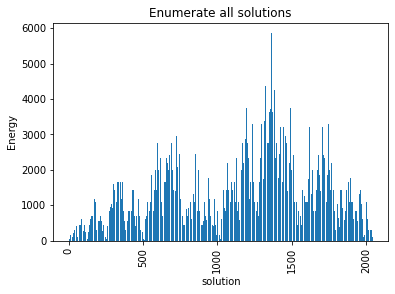

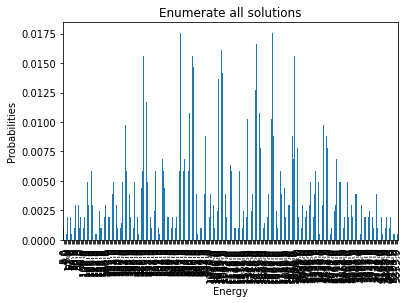

minimum energy: 5.0


In [17]:
plot_enumerate(exactSamples, title='Enumerate all solutions')
plot_energies(exactSamples, title='Enumerate all solutions')

Let's now solve this Ising Model via traditional Integer Programming.

In [19]:
# We do not need to worry about the tranformation from Ising to QUBO since dimod takes care of it
Q, c = model_ising.to_qubo()

# Define the model
model = pyo.ConcreteModel(name='Ising example as an IP, 47-779 QuIP')

I = range(len(h))
J = range(len(h))
#Define the original variables
model.x = pyo.Var(I, domain=pyo.Binary)
# Define the edges variables
model.y = pyo.Var(I, J, domain=pyo.Binary)

obj_expr = c

# add model constraints
model.c1 = pyo.ConstraintList()
model.c2 = pyo.ConstraintList()
model.c3 = pyo.ConstraintList()
for (i,j) in Q.keys():
    if i != j:
        model.c1.add(model.y[i,j] >= model.x[i] + model.x[j] - 1)
        model.c2.add(model.y[i,j] <= model.x[i])
        model.c3.add(model.y[i,j] <= model.x[j])
        obj_expr += Q[i,j]*model.y[i,j]
    else:
        obj_expr += Q[i,j]*model.x[i]

# Define the objective function
model.objective = pyo.Objective(expr = obj_expr, sense=pyo.minimize)
# Print the model
model.pprint()

Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain              : Size : Members
        None :     2 : y_index_0*y_index_1 :  121 : {(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 

In [21]:
# Let's install the MIP solver CBC
if IN_COLAB:
    !apt-get install -y -qq coinor-cbc

In [23]:
# Define the solver GLPK
if IN_COLAB:
    opt_cbc = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
else:
    opt_cbc = pyo.SolverFactory('cbc')
# Here we could use another solver, e.g. gurobi or cplex
# opt_gurobi = pyo.SolverFactory('gurobi')

In [25]:
# We obtain the same solution with CBC
result_obj = opt_cbc.solve(model, tee=False)
model.display()

Model Ising example as an IP, 47-779 QuIP

  Variables:
    x : Size=11, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary
          6 :     0 :   0.0 :     1 : False : False : Binary
          7 :     0 :   0.0 :     1 : False : False : Binary
          8 :     0 :   0.0 :     1 : False : False : Binary
          9 :     0 :   0.0 :     1 : False : False : Binary
         10 :     0 :   1.0 :     1 : False : False : Binary
    y : Size=121, Index=y_index
        Key      : Lower : Value : Upper : Fixed : Stale : Domain
          (0, 0) :     0 :  None :     1 : False :  True : Binary
          (0, 1) 

We observe that the optimal solution of this problem is $x_{10} = 1, 0$ otherwise, leading to an objective of $5$. Notice that this problem has a degenerate optimal solution given that $x_8 = 1, 0$ otherwise also leads to the same solution.

## Let's go back to the slides

Let's now solve this problem using Simulated Annealing

In [26]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model_ising, num_reads=1000)


minimum energy: 5.0


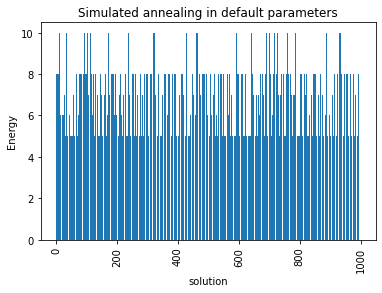

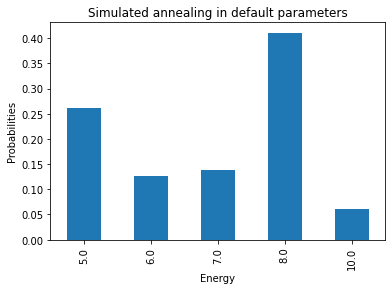

minimum energy: 5.0


In [27]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

We are going to use the default limits of temperature given by the simulating annealling code. These are defined using the minimum and maximum nonzero coefficients in the Ising model. Then the range for beta is defined as $\beta \in \left[ \frac{\log(2)}{\max \{ \Delta E \} },\frac{\log(100)}{\min \{ \Delta E \} } \right]$, where $\Delta E = \min \{h_i \} + \sum_j J_{ij}+J_{ji}$.

Hot temperature: We want to scale hot_beta so that for the most unlikely qubit flip, we get at least 50% chance of flipping. (This means all other qubits will have > 50% chance of flipping initially). Most unlikely flip is when we go from a very low energy state to a high energy state, thus we calculate hot_beta based on max_delta_energy.
$$
0.50 = \exp(-\overline{\beta} * \max \{ \Delta E \})
$$

Cold temperature: Towards the end of the annealing schedule, we want to minimize the chance of flipping. Don't want to be stuck between small energy tweaks. Hence, set cold_beta so that at minimum energy change, the chance of flipping is set to 1%.
$$
0.01 = \exp(-\underline{\beta} * \min \{ \Delta E \})
$$

By default, the schedule also follows a geometric series.

In [28]:
simAnnSamples.info

{'beta_range': [0.0008222386483510621, 0.19188209108283716],
 'beta_schedule_type': 'geometric'}

## Let's go back to the slides

Now let's compute an expected time metric with respect to the number of sweeps in simulated annealing.

In [29]:
s = 0.99
sweeps = list(chain(np.arange(1,10,1),np.arange(10,30,2), np.arange(30,50,5), np.arange(50,100,10) ,np.arange(100,1001,100)))
schedules = ['geometric','linear']
opt_energy = [5]
p = {}
tts = {}
for schedule in schedules:
    probs = []
    time_to_sol = []
    for sweep in sweeps:
        start = time.time()
        samples = simAnnSampler.sample(model_ising, num_reads=1000, num_sweeps=sweep, beta_schedule_type=schedule)
        if sweep == 1:
            tau = time.time() - start
        energies=samples.data_vectors['energy']
        occurrences = samples.data_vectors['num_occurrences']
        total_counts = sum(occurrences)
        counts = {}
        for index, energy in enumerate(energies):
            if energy in counts.keys():
                counts[energy] += occurrences[index]
            else:
                counts[energy] = occurrences[index]
        pr = sum(counts[key] for key in opt_energy if key in counts.keys())/total_counts
        probs.append(pr)
        time_to_sol.append(sweep*tau*math.log(1-s)/math.log(1-pr))
    p[schedule] = probs
    tts[schedule] = time_to_sol

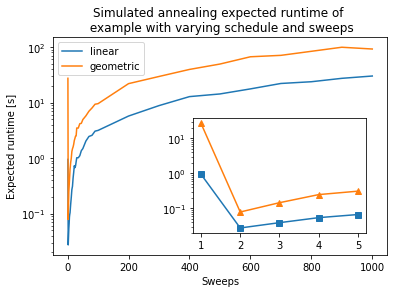

In [30]:

# plt.plot(sweeps,tts['linear'], label='linear')
# plt.plot(sweeps,tts['geometric'], label='geometric')


fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.semilogy(sweeps,tts['linear'],'-', label='linear')
ax1.semilogy(sweeps,tts['geometric'],'-', label='geometric')
plt.ylabel('Expected runtime [s]')
plt.xlabel('Sweeps')
plt.title('Simulated annealing expected runtime of \n' + ' example with varying schedule and sweeps')
plt.legend()

ax2 = plt.axes([.45, .2, .4, .4])
ax2.semilogy(sweeps[0:5],tts['linear'][0:5],'-s')
ax2.semilogy(sweeps[0:5],tts['geometric'][0:5],'-^')
